# EbayesThresh Python화 활용법

SEOYEON CHOI  
2024-05-29

# Install

In [7]:
# !pip install git+https://github.com/seoyeonc/ebayesthresh.git

  Cloning https://github.com/seoyeonc/ebayesthresh.git to /tmp/pip-req-build-gh560sa9
  Running command git clone --filter=blob:none --quiet https://github.com/seoyeonc/ebayesthresh.git /tmp/pip-req-build-gh560sa9
  Resolved https://github.com/seoyeonc/ebayesthresh.git to commit ed192d245edf36cd7b6df5ae8ae4b217ae63ac5a
  Preparing metadata (setup.py) ... done
  Created wheel for ebayesthresh: filename=ebayesthresh-0.0.1-py3-none-any.whl size=9740 sha256=da51a5730cd887fcf5e57fc12269c64cdb8626b7257caffa19d05f7bc5c344f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lix5_1s/wheels/64/9a/27/4ae710bcecb5e9068c9cf7034acefa27666251c621442dc422
Successfully built ebayesthresh

# Import

In [2]:
import ebayesthresh

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 예제를 위해 필요한 함수 정의

In [4]:
def make_Psi(T):
    W = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif np.abs(i-j) <= 1 : 
                W[i,j] = 1
    d = np.array(W.sum(axis=1))
    D = np.diag(d)
    L = np.array(np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d)))
    lamb, Psi = np.linalg.eigh(L)
    return Psi

# Example

In [16]:
T = 100
x = np.arange(T)/T * 10
y_true = 3*np.sin(0.5*x) + 1.2*np.sin(1.0*x) + 0.5*np.sin(1.2*x) 
y = y_true + np.random.normal(size=T)

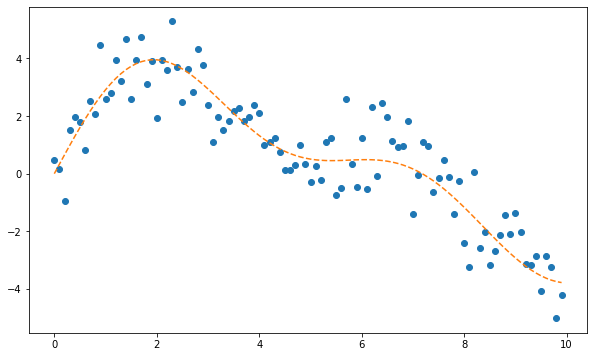

In [17]:
plt.figure(figsize=(10,6))
plt.plot(x,y,'o')
plt.plot(x,y_true,'--')

In [18]:
f = np.array(y)
if len(f.shape)==1: f = f.reshape(-1,1)
T,N = f.shape
Psi = make_Psi(T)
fbar = Psi.T @ f # apply dft 

In [19]:
fbar_threshed = ebayesthresh.ebayesthresh(fbar[:,0])

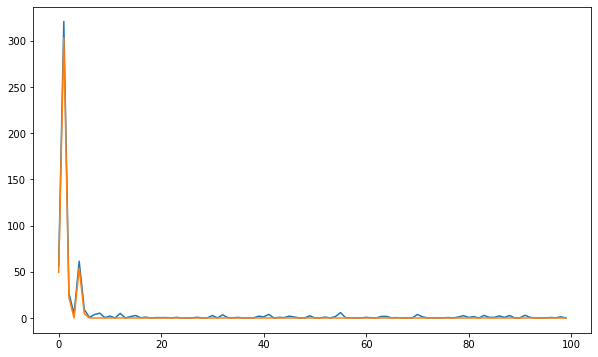

In [20]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)) # periodogram 
plt.plot((fbar_threshed**2)) 

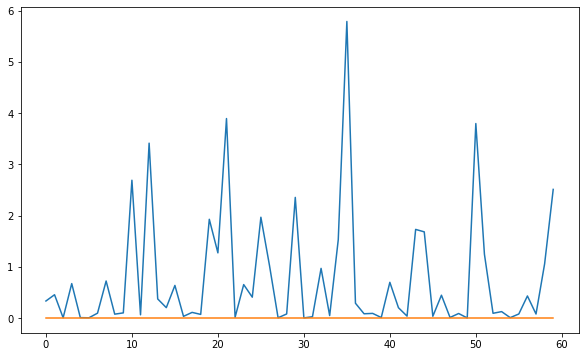

In [21]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)[20:80]) # periodogram 
plt.plot((fbar_threshed**2)[20:80]) 

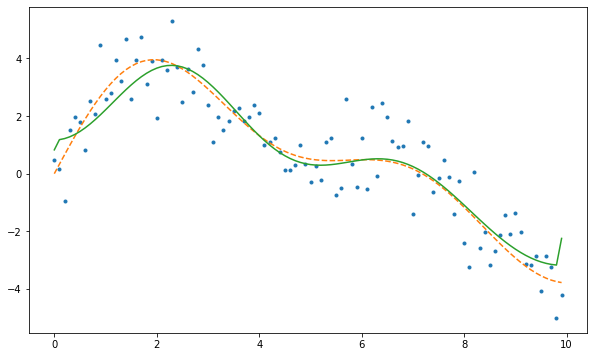

In [22]:
yhat = Psi @ fbar_threshed # inverse dft
plt.figure(figsize=(10,6))
plt.plot(x,y,'.')
plt.plot(x,y_true,'--')
plt.plot(x,yhat)

# 사용자 함수 정의

In [83]:
torch.tensor(0.0,requires_grad=True)

In [102]:
class ebayesthresh_nn(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.bayesfac = kwargs.get("bayesfac",True)
        self.verbose = kwargs.get('verbose', True)
        self.threshrule = kwargs.get('threshrule', 'median')
        self.universalthresh = kwargs.get('universalthresh', True)
        self.stabadjustment = kwargs.get('stabadjustment', None)
        self.prior = kwargs.get('prior', 'laplace')
        self.bayesfac = kwargs.get('bayesfac', False) 
        #--#
        self.a = torch.tensor(0.1,requires_grad=True); self.a.data = torch.tensor(kwargs.get('a', 0.5)).float()
        self.sdev = torch.tensor(0.1,requires_grad=True); self.sdev =  torch.tensor(kwargs.get('sdev', 0.5)).float()
        #prior="laplace", a = 0.5, bayesfac = False, sdev = None, verbose = True, threshrule = "median", universalthresh = True, stabadjustment = None
    def thresh(self):
        bayesfac= self.bayesfac
        verbose = self.verbose
        threshrule = self.threshrule
        universalthresh = self.universalthresh
        stabadjustment = self.stabadjustment
        prior = self.prior 
        bayesfac = self.bayesfac 
        #--#
        a = self.a 
        sdev = self.sdev

        if sdev is None:
            sdev = mad(x, center=0)
            stabadjustment_condition = True
        elif len(np.atleast_1d(sdev)) == 1:
            if stabadjustment is not None:
                raise ValueError("Argument stabadjustment is not applicable when variances are homogeneous.")
            if np.isnan(sdev):
                sdev = mad(x, center=0)
            stabadjustment_condition = True
        else:
            if pr == "c":
                raise ValueError("Standard deviation has to be homogeneous for Cauchy prior.")
            if len(sdev) != len(x):
                raise ValueError("Standard deviation has to be homogeneous or have the same length as observations.")
            if stabadjustment is None:
                stabadjustment = False
            stabadjustment_condition = stabadjustment

        if stabadjustment_condition:
            m_sdev = np.mean(sdev)
            s = sdev / m_sdev
            x = x / m_sdev
        else:
            s = sdev

        if (pr == "l") and np.isnan(a):
            pp = wandafromx(x, s, universalthresh)
            w = pp['w']
            a = pp['a']
        else:
            w = wfromx(x, s, prior=prior, a=a, universalthresh=universalthresh)

        if pr != "m" or verbose:
            tt = tfromw(w, s, prior=prior, bayesfac=bayesfac, a=a)[0]
            if stabadjustment_condition:
                tcor = tt * m_sdev
            else:
                tcor = tt

        if threshrule == "median":
            muhat = postmed(x, s, w, prior=prior, a=a)
        elif threshrule == "mean":
            muhat = postmean(x, s, w, prior=prior, a=a)
        elif threshrule == "hard":
            muhat = threshld(x, tt)
        elif threshrule == "soft":
            muhat = threshld(x, tt, hard=False)
            if threshrule == "none":
                muhat = None
        else:
            raise ValueError(f"Unknown threshold rule: {threshrule}")

        if stabadjustment_condition:
            muhat = muhat * m_sdev

        if not verbose:
            return muhat
        retlist = {
                'muhat': muhat,
                'x': x,
                'threshold.sdevscale': tt,
                'threshold.origscale': tcor,
                'prior': prior,
                'w': w,
                'a': a,
                'bayesfac': bayesfac,
                'sdev': sdev,
                'threshrule': threshrule
            }
        if pr == "c":
            del retlist['a']
        if threshrule == "none":
            del retlist['muhat']
        return retlist
    def forward(self,x):
        out = ebayesthresh.ebayesthresh(
            x,
            self.prior, 
            a=self.a, 
            bayesfac=self.bayesfac, 
            sdev=self.sdev, 
            verbose=self.verbose, 
            threshrule=self.threshrule, 
            universalthresh=self.universalthresh, 
            stabadjustment=self.stabadjustment
        )
        return out

> 데이터

In [103]:
np.random.seed(111)
T = 100
x = np.arange(T)/T * 10
ytrue = 3*np.sin(0.5*x) + 1.2*np.sin(1.0*x) + 0.5*np.sin(1.2*x) 
noise  = np.random.normal(size=T)*0.7
y = ytrue + noise

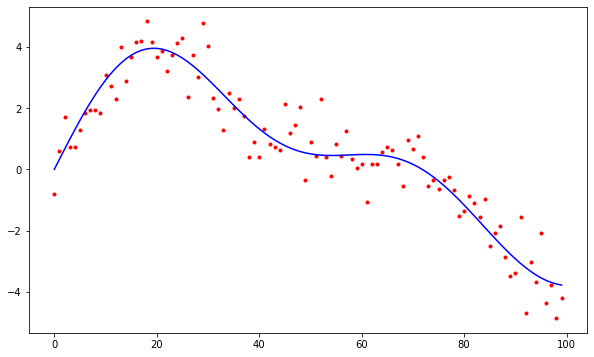

In [104]:
plt.figure(figsize=(10,6))
plt.plot(y,'.',color='r')
plt.plot(ytrue,'-',color='b')

> 레이어 정의

In [105]:
thresh_layer = ebayesthresh_nn()

> Fourier Transform

In [106]:
Psi = make_Psi(T)

In [107]:
ybar = Psi.T @ y

> Learn

In [ ]:
ebayesthresh.ebayesthresh??

In [99]:
power_threshed = thresh_layer(torch.tensor(ybar))

> Inverse Fourier Transform

In [30]:
ytrue_hat = Psi@power_threshed['muhat']

In [31]:
power_threshed

> Result

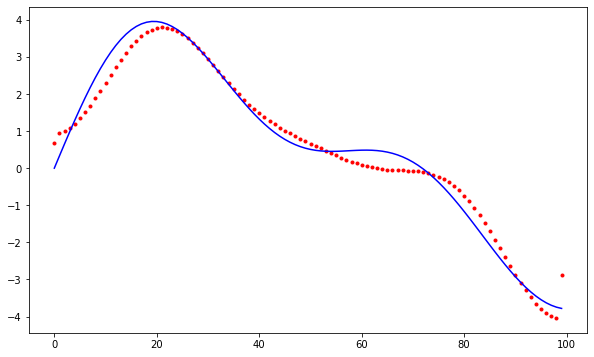

In [32]:
plt.figure(figsize=(10,6))
plt.plot(ytrue_hat,'.',color='r')
plt.plot(ytrue,'-',color='b')

> MSE

In [47]:
y = torch.tensor(y)
ytrue_hat = torch.tensor(ytrue_hat,requires_grad=True)

In [48]:
loss = torch.sum((y- ytrue_hat)**2)
loss

In [49]:
ytrue_hat.grad

In [50]:
loss.backward()

In [51]:
ytrue_hat.grad

In [53]:
ytrue_hat/y

In [56]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(thresh_layer.parameters(), lr=0.01)

In [52]:


# 학습
num_epochs = 1000  # 에폭 수
for epoch in range(num_epochs):
    # 순전파
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    
    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 로그 출력
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 학습된 모델을 통해 예측
predicted = model(x_tensor).detach().numpy()

In [57]:
??torch.nn.Linear